In [97]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar-10-batches-py/batches.meta
/kaggle/input/cifar-10-batches-py/test_batch
/kaggle/input/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar-10-batches-py/readme.html


In [98]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

In [99]:
# Caricamento del dataset batch 1-5
def load_dataset(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

xs = []
ys = []
for b in range(1,6):
    
    dataset = load_dataset("/kaggle/input/cifar-10-batches-py/data_batch_%d" % (b, ))
    X_data = dataset[b'data']
    Y_data = dataset[b'labels']
    xs.append(X_data)
    ys.append(Y_data)

X = np.concatenate(xs)
Y = np.concatenate(ys)

print("data batch 1 - 5:")
print('X:', X.shape)
print('Y:', Y.shape)

# Caricamento del dataset di test
dataset_test = load_dataset("/kaggle/input/cifar-10-batches-py/test_batch")
X_test = np.array(dataset[b'data'])
y_test = np.array(dataset[b'labels'])

#X = x.reshape(X.shape[0], X.shape[1])
#Y = np.array(y)
print("Test batch:")
print('X:', X_test.shape)
print('Y:', y_test.shape)



Importo il data batch 1
Importo il data batch 2
Importo il data batch 3
Importo il data batch 4
Importo il data batch 5
data batch 1 - 5:
X: (50000, 3072)
Y: (50000,)
Test batch:
X: (10000, 3072)
Y: (10000,)


In [100]:
# Divisione del dataset in train, validation e test
train_fraction = 0.7
validation_fraction = 0.3  

# svolgimento...
num_train = int(train_fraction * X.shape[0])
num_val = int(validation_fraction * X.shape[0])

X_train = X[:num_train]
y_train = Y[:num_train]

X_val = X[num_train:num_train + num_val]
y_val = Y[num_train:num_train + num_val]

print(f"Training set: {X_train.shape} osservazioni")
print(f"Validation set: {X_val.shape} osservazioni")
print(f"Test set: {X_test.shape} osservazioni")

Training set: (35000, 3072) osservazioni
Validation set: (15000, 3072) osservazioni
Test set: (10000, 3072) osservazioni


In [101]:
def plot_confusion_matrix_multiclass(cm):
    # Calcola dinamicamente le etichette delle classi
    class_labels = [f"Class {i}" for i in range(cm.shape[0])]

    print('Stampo la Confusion Matrix.')
    
    # Visualizza la heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return


def plot_decision_boundary(knn_model, X_train, y_train):
    h = 0.1  
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    print('Calcolo i confini decisionali...')
    
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    unique_classes = np.unique(y_train)

    print('Stampo i Decision Boundary.')
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.RdYlBu)  
    
    scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', 
                          label='Training set', cmap=plt.cm.RdYlBu, s=20)  

    plt.title(f'Confini Decisionali di K-Nearest Neighbors')
    plt.legend(scatter.legend_elements()[0], unique_classes, title='Classi')
    
    plt.show()
    
    return


def plot_decision_tree(model, feature_names, target_names):
    print('Stampo il Decision Tree.')

    plt.figure(figsize=(20, 10))
    plot_tree(model, feature_names=feature_names, class_names=target_names, 
              filled=True, rounded=True, fontsize=12)
    plt.title('Decision Tree')    
    plt.show()

    return

Funzioni di stampa definite.


In [102]:
def exec_pca(X, components = 0.95):
    #PCA

    print(f'Applico la PCA con {components} componenti.')
    
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X)
    
    return X_pca

def exec_stand(X):
    #Standardizzazione

    print('Applico la Standardizzazione.')
    
    scaler = StandardScaler()
    X_stand = scaler.fit_transform(X)  

    return X_stand

def pipeline (X_train, y_train, X_val, y_val, hyperparams):

    print('\nEseguo la pipeline con la seguente configurazione:', hyperparams)
    
    X_train_stand = exec_stand(X_train)
    X_val_stand =  exec_stand(X_val)

    if hyperparams['use_pca']:
        X_train_stand = exec_pca(X_train_stand, components = hyperparams['PCA_components'])
        X_val_stand = exec_pca(X_val_stand, components = hyperparams['PCA_components'])

    if hyperparams['classifier'] == 'LR':
        # creazione del modello di regressione Logistica
        #c = 1 no regolarizzazione (loss elevata) / c = 0 regolarizzazione massima (loss minima)
        model = LogisticRegression()

    if hyperparams['classifier'] == 'SVC':
        # creazione del modello SVM
        model = SVC()

    if hyperparams['classifier'] == 'KNN':
        # creazione del modello KNN
        model = KNeighborsClassifier()

    if hyperparams['classifier'] == 'DT':
        # creazione del modello Decision Tree
        model = DecisionTreeClassifier()

    clf = GridSearchCV(model, hyperparams['params'], cv=3, n_jobs=-1, verbose=1)

    print(f'Avvio la ricerca per trovare i parametri migliori per il modello di classificazione {hyperparams["classifier"]}...')
    
    clf.fit(X_train_stand, y_train)

    print('Ricerca terminata.')
    
   # clf.best_score_   # accuracy
   # clf.best_estimator_ # modello allenato
   # clf.best_params_  # configurazione parametri migliore
    
    print(f"Miglior CV Score = {clf.best_score_:.4f}")
    print(f"Migliori parametri:", clf.best_params_)

    best_model = clf.best_estimator_
    
    y_pred = best_model.predict(X_val_stand)
    
    """
    # traning del modello
    model.fit(X_train_stand, y_train)
    
    # predizione sul val
    y_pred = model.predict(X_val_stand)

    correct_valid = np.sum(y_val == y_pred)
    total_valid = len(y_val)
    acc_valid = correct_valid / total_valid if total_valid > 0 else 0 #percentuale (valore 0-1)
    
    # accuracy
    print(f"Validation accuracy: {acc_valid:.4f}")
    """
    
    # è il modello knn
    if (hyperparams['classifier'] == 'KNN' and hyperparams['plot_decision_boundary']):

        print(f'Rialleno il modello KNN usando features 2D per stamapre il decision boundary.')
        
        X_train_stand_knn = exec_stand(X_train)
        X_val_stand_knn =  exec_stand(X_val)
        
        X_train_stand_knn = exec_pca(X_train_stand_knn, components = 2)
        X_val_stand_knn = exec_pca(X_val_stand_knn, components = 2)
        
        model_knn = KNeighborsClassifier(**clf.best_params_)

        print('Avvio allenamento 2D...')
        
        # traning del modello
        model_knn.fit(X_train_stand_knn, y_train)

        print('Fine allenamento 2D.')
        
        # predizione sul val
        y_pred_knn = model_knn.predict(X_val_stand_knn)
    
        correct_valid_knn = np.sum(y_val == y_pred_knn)
        total_valid_knn = len(y_val)
        acc_valid_knn = correct_valid_knn / total_valid_knn if total_valid_knn > 0 else 0 #percentuale (valore 0-1)

         # accuracy
        print(f"KNN 2D - Validation accuracy: {acc_valid_knn:.4f}")

        plot_decision_boundary(model_knn, X_train_stand_knn, y_train)

        return clf
        
    
    # Calcolare la matrice di confusione
    cm = confusion_matrix(y_val, y_pred) # ...
    # Visualizzare la matrice di confusione
    plot_confusion_matrix_multiclass(cm)

    if (hyperparams['classifier'] == 'DT' and hyperparams['plot_decision_tree']):
        feature_names = range(len(X_train_stand))
        feature_names = [str(element) for element in feature_names]
        
        target_names = np.unique(y_train)
        target_names = [str(element) for element in target_names]
        
        # Stampa Decision Tree
        plot_decision_tree(clf.best_estimator_, feature_names, target_names)

    return clf

Funzione pipeline definita.



Eseguo la pipeline con la seguente configurazione: {'use_pca': True, 'PCA_components': 1024, 'classifier': 'LR', 'params': {'C': [0.01, 0.1, 1, 10], 'max_iter': [50, 500, 1000], 'solver': ['lbfgs']}}
Applico la Standardizzazione.
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Applico la PCA con 1024 componenti.
Avvio la ricerca per trovare i parametri migliori per il modello di classificazione LR...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ricerca terminata.
Miglior CV Score = 0.4005
Migliori parametri: {'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}
Stampo la Confusion Matrix.


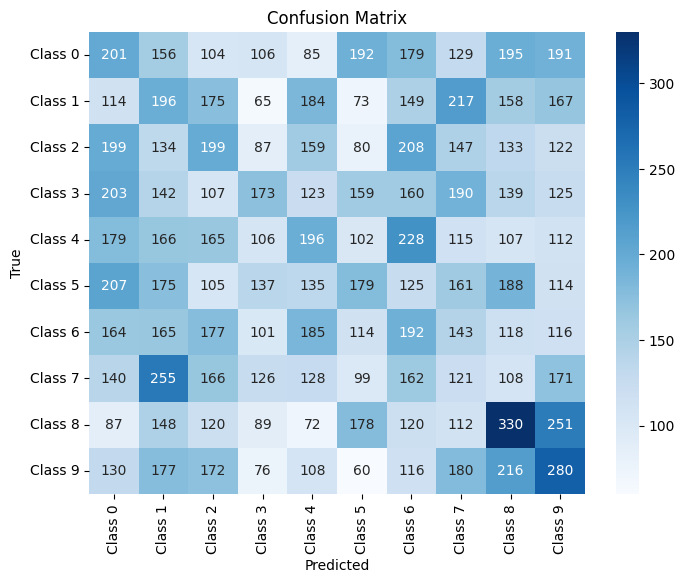


LR - Migliore configurazione di parametri: {'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}
LR - Accuracy: 0.4005

Eseguo la pipeline con la seguente configurazione: {'use_pca': True, 'PCA_components': 1024, 'classifier': 'SVC', 'params': {'C': [0.1, 1, 10], 'kernel': ['rbf']}}
Applico la Standardizzazione.
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Applico la PCA con 1024 componenti.
Avvio la ricerca per trovare i parametri migliori per il modello di classificazione SVC...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Ricerca terminata.
Miglior CV Score = 0.5221
Migliori parametri: {'C': 10, 'kernel': 'rbf'}
Stampo la Confusion Matrix.


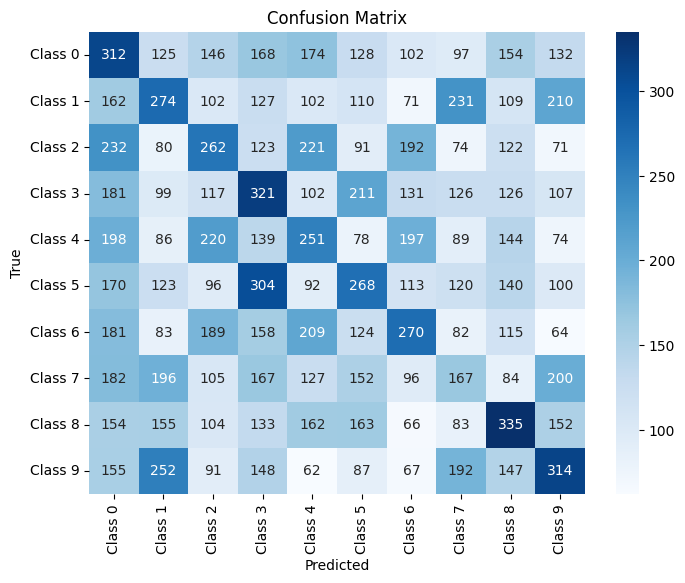


SVC - Migliore configurazione di parametri: {'C': 10, 'kernel': 'rbf'}
SVC - Accuracy: 0.5221

Eseguo la pipeline con la seguente configurazione: {'use_pca': True, 'PCA_components': 1024, 'classifier': 'KNN', 'plot_decision_boundary': False, 'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}}
Applico la Standardizzazione.
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Applico la PCA con 1024 componenti.
Avvio la ricerca per trovare i parametri migliori per il modello di classificazione KNN...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Ricerca terminata.
Miglior CV Score = 0.3315
Migliori parametri: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Stampo la Confusion Matrix.


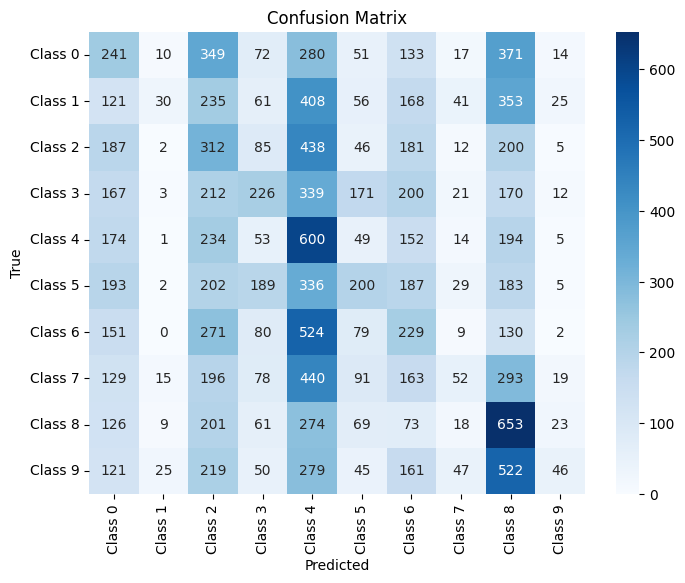


KNN - Migliore configurazione di parametri: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
KNN - Accuracy: 0.3315

Eseguo la pipeline con la seguente configurazione: {'use_pca': True, 'PCA_components': 1024, 'classifier': 'DT', 'plot_decision_tree': False, 'params': {'max_depth': [10, 20, 30], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5]}}
Applico la Standardizzazione.
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Applico la PCA con 1024 componenti.
Avvio la ricerca per trovare i parametri migliori per il modello di classificazione DT...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Ricerca terminata.
Miglior CV Score = 0.2822
Migliori parametri: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
Stampo la Confusion Matrix.


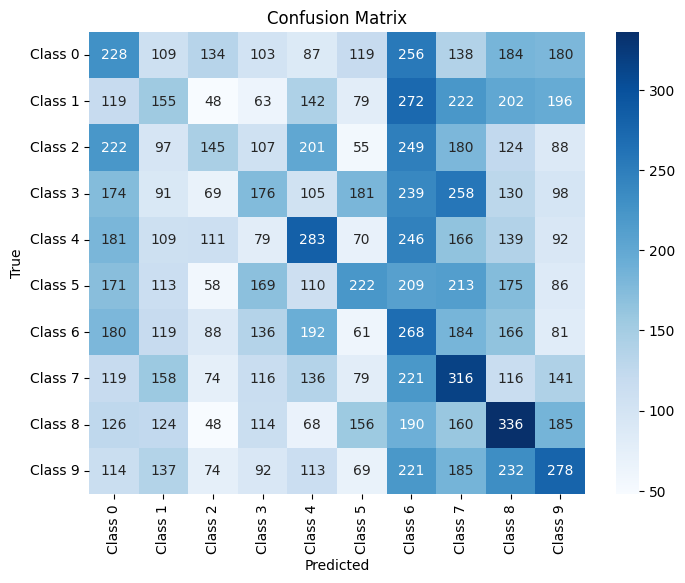


DT - Migliore configurazione di parametri: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
DT - Accuracy: 0.2822

Configurazione migliore per ogni modello:
LR: (Acc. 0.4005) -> {'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}
SVC: (Acc. 0.5221) -> {'C': 10, 'kernel': 'rbf'}
KNN: (Acc. 0.3315) -> {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
DT: (Acc. 0.2822) -> {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}

Verifico l'accuracy sul batch di test per ogni miglior modello trovato e seleziono quello con accuracy più alta.

Testo LR:
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Model LR: accuracy 0.1318

Testo SVC:
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Model SVC: accuracy 0.1933

Testo KNN:
Applico la Standardizzazione.
Applico la PCA con 1024 componenti.
Model KNN: accuracy 0.1785

Testo DT:
Applico la Standardizzazione.
Applico la PCA con 1

In [103]:
pca_components = 1024

hyperparams = [    
       {
        # Logistic Regression
        'use_pca' : True,
        'PCA_components' : pca_components,
        'classifier' : 'LR',
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'max_iter' : [50, 500, 1000],
            'solver' : ['lbfgs'],
        }
    },
    {
        # SVM
        'use_pca' : True,
        'PCA_components' : pca_components,
        'classifier' : 'SVC',
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf']
        }
    },
    {
        # KNN 
        'use_pca' : True,
        'PCA_components' : pca_components, 
        'classifier' : 'KNN',     
        'plot_decision_boundary' : False,
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric' : ['euclidean', 'manhattan']
        }
    }, 
    {
        # Decision Tree
        'use_pca' : True,
        'PCA_components' : pca_components, 
        'classifier' : 'DT',
        'plot_decision_tree': False,
        'params': {
            'max_depth': [10, 20, 30],
            'criterion': ['gini', 'entropy'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5]
        }
    },
]

best_hyperparams = {}

for config in hyperparams: 
    
    clf = pipeline(X_train, y_train, X_val, y_val, config)
    
    best_hyperparams[config['classifier']] = clf

    print(f'\n{config["classifier"]} - Migliore configurazione di parametri:', clf.best_params_)
    print(f'{config["classifier"]} - Accuracy: {clf.best_score_:.4f}')

print('\nConfigurazione migliore per ogni modello:')
for name, clf in best_hyperparams.items():
    print(f'{name}: (Acc. {clf.best_score_:.4f}) -> {clf.best_params_}')

print("\nVerifico l'accuracy sul batch di test per ogni miglior modello trovato e seleziono quello con accuracy più alta.")

best_acc = 0
best_clf = None
for name, clf in best_hyperparams.items():
    print(f'\nTesto {name}:')
    
    model = clf.best_estimator_

    X_test_stand = exec_stand(X_test)
    X_test_stand = exec_pca(X_test_stand, components = pca_components)
    y_test_pred = model.predict(X_test_stand)

    correct_valid = np.sum(y_test == y_test_pred)
    total_valid = len(y_test)
    acc_valid = correct_valid / total_valid if total_valid > 0 else 0 #percentuale (valore 0-1)

    print(f'Model {name}: accuracy {acc_valid:.4f}')
    
    if (acc_valid > best_acc):
        best_acc = acc_valid
        best_clf = clf

print("\nIl modello migliore tra tutti è: ", best_clf.best_estimator_)
print('usando la seguente configurazione:', best_clf.best_params_)
print(f'con una precisione di {best_acc:.4f} sul batch di test')
    